---
##### What does this notebook prepare.py` do? – cleaning and labelling

**Big idea**   
Start with two enormous JSON files (15.7 M reviews + 2.3 M books) and boil them down to a tidy CSV of *English* reviews that have enough reader activity to measure “popularity”.

**Step-by-step**

1. **Keep only engaged reviews** – Skip any review whose `n_votes + n_comments` is 0.   
   *Example* : A review with 3 likes and 1 comment stays; a review with 0 likes, 0 comments is discarded.
2. **Remove quiet books** – If a book has fewer than **10 total reviews** **or** fewer than **60 combined likes+comments** across all its reviews, throw all its reviews away.  This ensures we can judge “popular within its crowd”.
3. **English-only filter** – Run Facebook’s fastText language-ID model.  Keep only rows predicted `__label__en` with probability ≥ 0.9.  Roughly 84 % survive.
4. **Create helper columns**
   * `review_likes` = likes + comments  
   * `book_review_likes` = total likes/comments for that book  
   * `like_share` = `review_likes` ÷ `book_review_likes`
5. **Binary target** – `popular = 1` if `like_share > 0.02`, else 0.  (≈ 21 % positives).
6. **Days since review** – Convert Goodreads timestamp to datetime and compute how many days have passed.  
7. **Count reviews per user** – `user_reviews` column (experience proxy).  
8. **Save** – dump everything to `filtered_reviews.csv`.

In [1]:
!pip install fasttext

  Installing build dependencies ... one
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp312-cp312-macosx_15_0_arm64.whl size=307504 sha256=41d53fc323a7e884371a68b2b45ea403fbeb3184f60c0232f016da8c00a7d8a6
  Stored in directory: /Users/vasu/Library/Caches/pip/wheels/20/27/95/a7baf1b435f1cbde017cabdf1e9688526d2b0e929255a359c6
Successfully built fasttext

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
import random
import urllib.request
import gzip
import matplotlib.pyplot as plt 
import json
import pandas as pd
import numpy as np
import fasttext

##### Parse the files and read the number of books/reviews

In [3]:
# updated paths to match your Drive
review_path = "../data/goodreads_reviews_dedup.json.gz"
book_path = "../data/goodreads_books.json.gz"

# read review data, removing entries with 0 likes
reviews = []
total_reviews = 0
with gzip.open(review_path, 'rt', encoding='utf-8') as f:
    for line in f:
        total_reviews += 1
        entry = json.loads(line)
        if entry['n_votes'] + entry['n_comments'] > 0:
            reviews.append(entry)

print("total_reviews: ", total_reviews)

total_reviews:  15739967


In [4]:
reviews[0]

{'user_id': '8842281e1d1347389f2ab93d60773d4d',
 'book_id': '24375664',
 'review_id': '5cd416f3efc3f944fce4ce2db2290d5e',
 'rating': 5,
 'review_text': "Mind blowingly cool. Best science fiction I've read in some time. I just loved all the descriptions of the society of the future - how they lived in trees, the notion of owning property or even getting married was gone. How every surface was a screen. \n The undulations of how society responds to the Trisolaran threat seem surprising to me. Maybe its more the Chinese perspective, but I wouldn't have thought the ETO would exist in book 1, and I wouldn't have thought people would get so over-confident in our primitive fleet's chances given you have to think that with superior science they would have weapons - and defenses - that would just be as rifles to arrows once were. \n But the moment when Luo Ji won as a wallfacer was just too cool. I may have actually done a fist pump. Though by the way, if the Dark Forest theory is right - and I

In [4]:
# convert to DF, retaining only relevant columns
reviews = pd.DataFrame(reviews, columns=['user_id','book_id','rating','review_text','date_added','n_votes','n_comments'])
print("reviews with 1+ like/comment: ", len(reviews))

reviews with 1+ like/comment:  4706961


In [5]:
reviews.head()

,user_id,book_id,rating,review_text,date_added,n_votes,n_comments
0,8842281e1d1347389f2ab93d60773d4d,24375664,5,Mind blowingly cool. Best science fiction I've...,Fri Aug 25 13:55:02 -0700 2017,16,0
1,8842281e1d1347389f2ab93d60773d4d,18245960,5,This is a special book. It started slow for ab...,Sun Jul 30 07:44:10 -0700 2017,28,1
2,8842281e1d1347389f2ab93d60773d4d,6392944,3,I haven't read a fun mystery book in a while a...,Mon Jul 24 02:48:17 -0700 2017,6,0
3,8842281e1d1347389f2ab93d60773d4d,22078596,4,"Fun, fast paced, and disturbing tale of murder...",Mon Jul 24 02:33:09 -0700 2017,22,4
4,8842281e1d1347389f2ab93d60773d4d,6644782,4,A fun book that gives you a sense of living in...,Mon Jul 24 02:28:14 -0700 2017,8,0


In [6]:
# calculate number of reviews per user
user_reviews = reviews.groupby("user_id")["book_id"].count().rename("user_reviews")
user_reviews.head()

user_id
00000377eea48021d3002730d56aca9a     1
00009ab2ed8cbfceda5a59da40966321     1
00009e46d18f223a82b22da38586b605    11
0000c3d51aa099745e93a4e99c4856c8    68
0001085188e302fc6b2568de45a5f56b     2
Name: user_reviews, dtype: int64

In [7]:
# combine votes and comments
reviews["review_likes"] = reviews["n_votes"] + reviews["n_comments"]
# reviews = reviews.drop(["n_votes","n_comments"],axis=1)
reviews.head()

,user_id,book_id,rating,review_text,date_added,n_votes,n_comments,review_likes
0,8842281e1d1347389f2ab93d60773d4d,24375664,5,Mind blowingly cool. Best science fiction I've...,Fri Aug 25 13:55:02 -0700 2017,16,0,16
1,8842281e1d1347389f2ab93d60773d4d,18245960,5,This is a special book. It started slow for ab...,Sun Jul 30 07:44:10 -0700 2017,28,1,29
2,8842281e1d1347389f2ab93d60773d4d,6392944,3,I haven't read a fun mystery book in a while a...,Mon Jul 24 02:48:17 -0700 2017,6,0,6
3,8842281e1d1347389f2ab93d60773d4d,22078596,4,"Fun, fast paced, and disturbing tale of murder...",Mon Jul 24 02:33:09 -0700 2017,22,4,26
4,8842281e1d1347389f2ab93d60773d4d,6644782,4,A fun book that gives you a sense of living in...,Mon Jul 24 02:28:14 -0700 2017,8,0,8


In [ ]:
# read book data, removing books with fewer than 10 reviews
books = []
total_books = 0
with gzip.open(book_path, 'rt', encoding='utf-8') as f:  # <-- gzip.open + 'rt' mode here too
    for line in f:
        total_books += 1
        entry = json.loads(line)
        try:
            if int(entry['text_reviews_count']) > 0:
                books.append(entry)
        except:
            pass

In [26]:
print("total_books: ", total_books)
print("shortlisted books: ", len(books))

total_books:  2360655
shortlisted books:  2359404


In [25]:
random_books = random.sample(books, 1)
for book in random_books:
    print(book)

{'isbn': '1499346603', 'text_reviews_count': '1', 'series': [], 'country_code': 'US', 'language_code': 'eng', 'popular_shelves': [], 'asin': '', 'is_ebook': 'false', 'average_rating': '5.00', 'kindle_asin': '', 'similar_books': [], 'description': 'R. Jack Winter\'s debut novel, GANI & SEAN follows two assassins whose paths cross when one fails to fulfill her contract to kill the other. Sean LePen misses her first shot when she realizes her target, Gani Jaksic is a man she admires for years, since her days in weapons training under his tutelage. When her boss Kristoff Koczella - the brutal and bizarre Chicago kingpin - discovers his assassin\'s mistake, he hires a highly skilled hit man known as "the voice" to kill her and her target, Gani.\nSean flees across country with both Gani and "the voice" on her trail. Will she escape? Will Gani?', 'format': 'Paperback', 'link': 'https://www.goodreads.com/book/show/22468647-gani-sean', 'authors': [{'author_id': '8305679', 'role': ''}], 'publish

In [27]:
print("total_reviews: ", total_reviews)
print("reviews with 1+ like/comment: ", len(reviews))
print("total_books: ", total_books)

total_reviews:  15739967
reviews with 1+ like/comment:  4706961
total_books:  2360655


In [28]:
# convert to DF, retaining only relevant columns
books = pd.DataFrame(books, columns=["book_id","text_reviews_count","ratings_count","average_rating"])
print("books with 10+ reviews: ", len(books))

books with 10+ reviews:  2359404


In [29]:
books.head()

,book_id,text_reviews_count,ratings_count,average_rating
0,5333265,1,3,4.00
1,1333909,6,10,3.23
2,7327624,7,140,4.03
3,6066819,3282,51184,3.49
4,287140,5,15,3.40


In [30]:
# join reviews and books
dat = pd.merge(reviews,books,on="book_id")
print("join reviews/books: ", len(dat))

join reviews/books:  4706729


In [33]:
dat.head()

,user_id,book_id,rating,review_text,date_added,n_votes,n_comments,review_likes,text_reviews_count,ratings_count,average_rating
0,8842281e1d1347389f2ab93d60773d4d,24375664,5,Mind blowingly cool. Best science fiction I've...,Fri Aug 25 13:55:02 -0700 2017,16,0,16,154,2925,4.38
1,8842281e1d1347389f2ab93d60773d4d,18245960,5,This is a special book. It started slow for ab...,Sun Jul 30 07:44:10 -0700 2017,28,1,29,374,6336,4.01
2,8842281e1d1347389f2ab93d60773d4d,6392944,3,I haven't read a fun mystery book in a while a...,Mon Jul 24 02:48:17 -0700 2017,6,0,6,42,675,3.80
3,8842281e1d1347389f2ab93d60773d4d,22078596,4,"Fun, fast paced, and disturbing tale of murder...",Mon Jul 24 02:33:09 -0700 2017,22,4,26,28,429,4.00
4,8842281e1d1347389f2ab93d60773d4d,6644782,4,A fun book that gives you a sense of living in...,Mon Jul 24 02:28:14 -0700 2017,8,0,8,8,98,3.76


##### Download the model

In [36]:
# Model filename
model_path = 'lid.176.bin'

# Check if the model file exists
if not os.path.exists(model_path):
    print("Model not found, downloading...")
    url = 'https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin'
    urllib.request.urlretrieve(url, model_path)
    print("Download complete.")

# Load the model
language_model = fasttext.load_model(model_path)

Model not found, downloading...
Download complete.


In [45]:
dat['review_likes'].value_counts()

review_likes
1       2176483
2        852482
3        444386
4        269989
5        177754
         ...   
580           1
1198          1
527           1
1124          1
862           1
Name: count, Length: 882, dtype: int64

In [46]:
# calculate total review likes per book
book_review_likes = dat.groupby("book_id")["review_likes"].sum().rename("book_review_likes")

# remove books with fewer than 100 total likes on reviews
book_review_likes = book_review_likes[book_review_likes>=100]
dat = dat.merge(book_review_likes,on='book_id')
print("reviews on books with 100+ review likes: ", len(dat))

reviews on books with 60+ review likes:  2027220


In [47]:
dat.head()

,user_id,book_id,rating,review_text,date_added,n_votes,n_comments,review_likes,text_reviews_count,ratings_count,average_rating,book_review_likes
0,8842281e1d1347389f2ab93d60773d4d,18245960,5,This is a special book. It started slow for ab...,Sun Jul 30 07:44:10 -0700 2017,28,1,29,374,6336,4.01,199
1,8842281e1d1347389f2ab93d60773d4d,16981,3,Recommended by Don Katz. Avail for free in Dec...,Mon Dec 05 10:46:44 -0800 2016,1,0,1,3741,125232,3.84,631
2,8842281e1d1347389f2ab93d60773d4d,28684704,3,"A fun, fast paced science fiction thriller. I ...",Tue Nov 15 11:29:22 -0800 2016,22,0,22,1026,13990,4.10,1010
3,8842281e1d1347389f2ab93d60773d4d,27161156,0,Recommended reading to understand what is goin...,Wed Nov 09 17:37:04 -0800 2016,5,1,6,13663,99022,3.96,4340
4,8842281e1d1347389f2ab93d60773d4d,32283133,0,http://www.telegraph.co.uk/culture/10...,Tue Nov 01 11:09:18 -0700 2016,9,0,9,3061,17494,3.86,1436


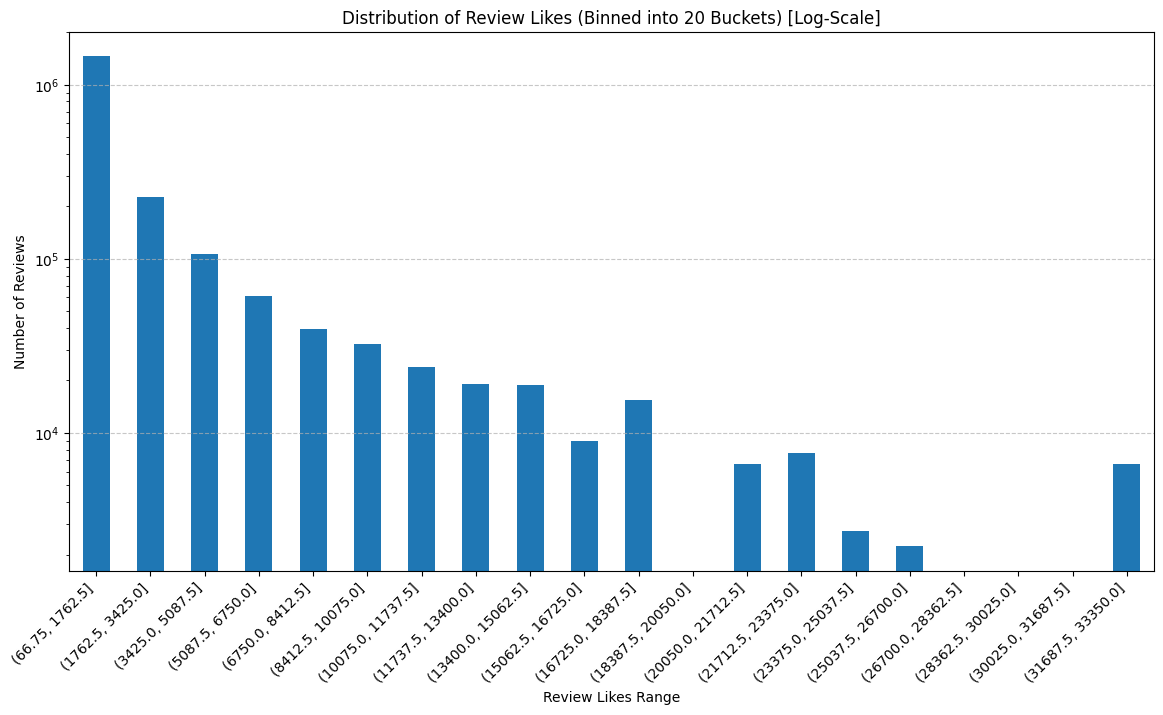

In [49]:
# Step 1: Use pd.cut directly on a copy
like_bins = pd.cut(dat['book_review_likes'], bins=20)

# Step 2: Get distribution counts
like_bin_distribution = like_bins.value_counts().sort_index()

# Step 3: Plot
plt.figure(figsize=(14, 7))
like_bin_distribution.plot(kind='bar')

plt.yscale('log')
plt.title('Distribution of Review Likes (Binned into 20 Buckets) [Log-Scale]')
plt.xlabel('Review Likes Range')
plt.ylabel('Number of Reviews')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.show()

In [50]:
# calculate like share
dat["like_share"] = dat["review_likes"]/dat["book_review_likes"]

# create popularity binary variable
popular_thresh = 0.02
dat["popular"] = np.where(dat["like_share"]>popular_thresh,1,0)

dat.head()

,user_id,book_id,rating,review_text,date_added,n_votes,n_comments,review_likes,text_reviews_count,ratings_count,average_rating,book_review_likes,like_share,popular
0,8842281e1d1347389f2ab93d60773d4d,18245960,5,This is a special book. It started slow for ab...,Sun Jul 30 07:44:10 -0700 2017,28,1,29,374,6336,4.01,199,0.145729,1
1,8842281e1d1347389f2ab93d60773d4d,16981,3,Recommended by Don Katz. Avail for free in Dec...,Mon Dec 05 10:46:44 -0800 2016,1,0,1,3741,125232,3.84,631,0.001585,0
2,8842281e1d1347389f2ab93d60773d4d,28684704,3,"A fun, fast paced science fiction thriller. I ...",Tue Nov 15 11:29:22 -0800 2016,22,0,22,1026,13990,4.10,1010,0.021782,1
3,8842281e1d1347389f2ab93d60773d4d,27161156,0,Recommended reading to understand what is goin...,Wed Nov 09 17:37:04 -0800 2016,5,1,6,13663,99022,3.96,4340,0.001382,0
4,8842281e1d1347389f2ab93d60773d4d,32283133,0,http://www.telegraph.co.uk/culture/10...,Tue Nov 01 11:09:18 -0700 2016,9,0,9,3061,17494,3.86,1436,0.006267,0


In [53]:
print("pre english filter popularity count:")
print(dat.groupby("popular")["user_id"].count())

pre english filter popularity count:
popular
0    1725317
1     301903
Name: user_id, dtype: int64


In [57]:
# filter to books in English
language_model = fasttext.load_model('lid.176.bin')
pred = language_model.predict(dat["review_text"].str.replace('\n','').to_list())
keep_ind = [i for i in range(len(pred[0])) if pred[0][i][0] == '__label__en' and pred[1][i][0] > .90]
dat = dat.iloc[keep_ind,].reset_index(drop=True)
print("english reviews: ", len(dat))

english reviews:  1710198


In [ ]:
# create days since added column
review_dates = pd.to_datetime(pd.to_datetime(dat["date_added"],format='%a %b %d %H:%M:%S %z %Y',errors='coerce'),utc=True,errors='coerce')
dat["days_since_review"] = (max(review_dates) - review_dates).dt.days

# add user_reviews column
dat = dat.merge(user_reviews,on='user_id')

In [60]:
# rename and reorder columns
dat = dat.rename(columns={"rating": "user_rating", "text_reviews_count":"book_reviews", "average_rating":"avg_rating"})
dat = dat[["user_id", "book_id", "user_reviews", "user_rating", "avg_rating", "ratings_count", "review_text", "days_since_review", "review_likes", "like_share", "popular"]]
print("final length: ", len(dat))

final length:  1710198


In [62]:
dat.sample(5)

,user_id,book_id,user_reviews,user_rating,avg_rating,ratings_count,review_text,days_since_review,review_likes,like_share,popular
389241,d017f36b4a3844f25bfd9c0c0e20c0c1,33928870,240,5,4.32,1044,Should I be scared? Afraid? Happy? Excited? We...,221,2,0.002513,0
107419,b0349696a6e57285497085a8d16212f0,23899174,10,5,3.51,42060,A really great read!! What I like best about t...,413,1,0.002227,0
1346016,e91c8245c5e65fae34ec3bf7fd9479f0,33016249,1,5,4.46,2988,I absolutely loved this book. Since I was youn...,144,1,0.002336,0
484216,93e91a7280ff388614923bcef2821dbe,21870140,1,3,4.07,94,A very wild surreal romp lead by the fabulousn...,1132,1,0.006711,0
344458,a01f55c72e260953c8bb762dc96bf269,6931356,150,1,3.86,140645,I think YA has had quite a lot of girls who ma...,1202,12,0.002657,0


##### Save filtered_reviews.csv in the current repository

In [63]:
save_path = '../data/filtered_reviews.csv'
dat.to_csv(save_path, index=False)

##### Peek at the filetered_reviews dataset

In [64]:
filtered_reviews = pd.read_csv(save_path)

In [65]:
len(filtered_reviews)

1710198

Each row refers to a single review given by a user

In [66]:
filtered_reviews.head(2)

,user_id,book_id,user_reviews,user_rating,avg_rating,ratings_count,review_text,days_since_review,review_likes,like_share,popular
0,8842281e1d1347389f2ab93d60773d4d,18245960,218,5,4.01,6336,This is a special book. It started slow for ab...,96,29,0.145729,1
1,8842281e1d1347389f2ab93d60773d4d,28684704,218,3,4.10,13990,"A fun, fast paced science fiction thriller. I ...",353,22,0.021782,1


In [69]:
filtered_reviews['review_text'][np.random.randint(low=0,high=1710198)]

'Two words: wesley ayers \n I would say this book is actually around a 3.6ish rating instead of a full 4 stars. [only because it took me a while to get into] \n There was a lot of information at the beginning and while I knew it was necessary, I still felt compelled to skim it over. [I\'m so glad I didn\'t lol] \n Once the action started, it never stopped . There was a sense of urgency at every turn and Mac was on a mission. A deathly mission (excuse the pun). Mac\'s mind is interesting. She\'s in the middle of an intense grief and the way it influences her decisions, the way she talks, and acts was fascinating and I\'m glad her grief was ingrained in every step she took, even if it was horribly awful to read about. \n The second half was amazing, I couldn\'t put it down and while, I predicted the "major twist" way beforehand, I thought how Schwab executed it was creepy as hell, but very fitting. \n ANOTHER NOTE: wesley ayers is my fav'

like_share_bin
(-0.00097, 0.05]    1594148
(0.05, 0.1]           56517
(0.1, 0.15]           20764
(0.15, 0.2]           11025
(0.2, 0.25]            6663
(0.25, 0.3]            4475
(0.3, 0.35]            3156
(0.35, 0.4]            2414
(0.4, 0.45]            1760
(0.45, 0.5]            1453
(0.5, 0.55]            1156
(0.55, 0.6]             978
(0.6, 0.65]             840
(0.65, 0.7]             727
(0.7, 0.75]             612
(0.75, 0.8]             539
(0.8, 0.85]             483
(0.85, 0.9]             537
(0.9, 0.95]             545
(0.95, 1.0]            1406
Name: count, dtype: int64


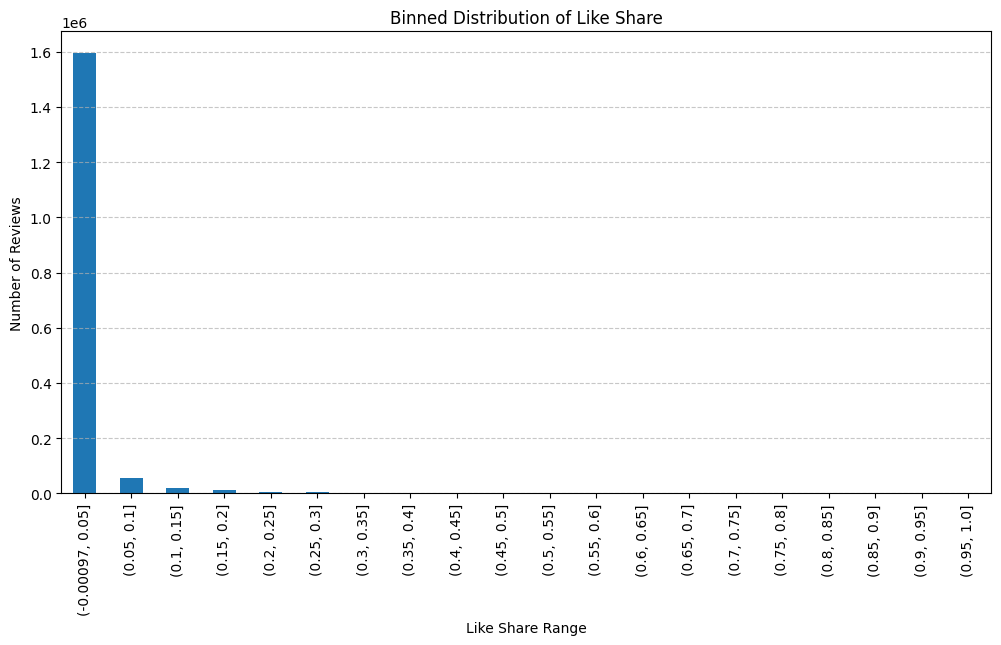

In [72]:
# Bin into 10 equal-width buckets
filtered_reviews['like_share_bin'] = pd.cut(filtered_reviews['like_share'], bins=20)

# Then see distribution
print(filtered_reviews['like_share_bin'].value_counts().sort_index())

# Or plot
filtered_reviews['like_share_bin'].value_counts().sort_index().plot(kind='bar', figsize=(12,6))
plt.title('Binned Distribution of Like Share')
plt.xlabel('Like Share Range')
plt.ylabel('Number of Reviews')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()